In [1]:
import os
import glob
import hist
import dask
import uproot
import awkward as ak
import dask_awkward as da
import dask.dataframe as dd
import dask_histogram as dh
from dask.diagnostics import ProgressBar
import boost_histogram as bh
from particle import Particle, ParticleNotFound

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd

import time

# Loading using dask

In [2]:
data_path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron"
data_Version = "05ae152"
data_Material = "Polyethylene25"
data_file_pattern = "5cm"

min_data_file_size = 5 * 1024 * 1024
data_files = glob.glob(f"{data_path}/{data_Version}/{data_Material}/{data_file_pattern}_*.root")
print(f"Found {len(data_files)} files matching pattern '{data_file_pattern}' in '{data_path}/{data_Version}/{data_Material}/'.")

uproot_files = [{f:"events/events"} for f in data_files if os.path.getsize(f) > min_data_file_size]
print(f"Available keys in uproot files: {uproot.open(uproot_files[0]).keys()}")

Found 100 files matching pattern '5cm' in '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/05ae152/Polyethylene25/'.
Available keys in uproot files: ['eventid', 'type_pri', 'type_pri_id', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri', 'cx_pri', 'cy_pri', 'cz_pri', 'vol_pri', 'vol_pri_hash', 'NSave', 'Save_flag', 'Save_desc', 'Save_type', 'Save_x', 'Save_y', 'Save_z', 'Save_cx', 'Save_cy', 'Save_cz', 'Save_e', 'Save_t', 'Save_eventid', 'Save_trackid', 'Save_volume', 'NNAct', 'NAct_eventid', 'NAct_trackid', 'NAct_parentid', 'NAct_t', 'NAct_volume', 'NAct_volume_hash', 'NAct_x', 'NAct_y', 'NAct_z', 'NAct_process_name', 'NAct_process_category', 'NAct_process_ID', 'NAct_particle_name', 'NAct_particle_lifetime', 'NAct_particle_id', 'NAct_particle_atomicnumber', 'NAct_particle_mass', 'NAct_particle_excitationEnergy']


In [3]:
pictures_path = '/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures'
if not os.path.exists(f'{pictures_path}/{data_Version}/{data_Material}'):
    os.makedirs(f'{pictures_path}/{data_Version}/{data_Material}')

## Meta-Daten und Tabellen für IDs

In [4]:
file = f"/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/{data_Version}/{data_Material}/{data_file_pattern}_0.root"
rfile = uproot.open(file)

print(f"The file contains {len(rfile.keys())} keys:")
for key in rfile.keys():
    print(f"  {key}")

print(f"\nExecuted with G4VERSION {rfile['G4VERSION_TAG'].member('fTitle')}")
print(f"Total runtime: {rfile['G4RUNTIME'].member('fVal')} seconds")
print(f"Number of events: {rfile['events/nbevents'].member('fVal')}")

print(f"\nUsing the macros:")
for macro in rfile["macros"].keys():
    print(f"--> {rfile['macros'][macro].member('fName')}")
    print(f"    File content hidden for brevity ...")
    for line in rfile["macros"][macro].member('fTitle').splitlines():
        print(f"    {line}")
    print("")

The file contains 31 keys:
  G4VERSION_TAG;1
  MC_TAG;1
  MCVERSION_TAG;1
  macros;1
  macros/preinit.mac;1
  macros/det_setup.mac;1
  macros/src_neutron.mac;1
  tables;1
  tables/neutronXS_G4_AIR;1
  tables/neutronXS_G4_WATER;1
  tables/neutronXS_G4_Galactic;1
  tables/neutronXS_LXe;1
  tables/neutronXS_LXe_nA;1
  tables/neutronXS_Rock;1
  tables/neutronXS_Concrete;1
  tables/neutronXS_SS304LSteel;1
  tables/neutronXS_Paraffin;1
  tables/neutronXS_Paraffin25;1
  tables/neutronXS_Polyethylen;1
  tables/neutronXS_Polyethylen5;1
  tables/neutronXS_Polyethylen25;1
  tables/neutronXS_Polyethylen7Lit;1
  tables/neutronXS_Silicone5;1
  tables/neutronXS_Silicone25Lit6;1
  tables/process_subtypes;1
  tables/logical_volumes;1
  tables/physical_volumes;1
  events;1
  events/nbevents;1
  events/events;1
  G4RUNTIME;1

Executed with G4VERSION $Name: geant4-10-06-patch-02 $
Total runtime: 885.341211966 seconds
Number of events: 100000

Using the macros:
--> preinit.mac
    File content hidden for b

In [5]:
rfile = uproot.open('/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/0ad7977/Polyethylene5/5cm_0.root')

physical_volumes = {}
for k,v in zip(*rfile["tables/physical_volumes"].arrays(library="np", how=list)):
    physical_volumes = {**physical_volumes, **{k: v for k, v in zip(k, v)}}

def get_volume_name(volume_id):
    """Get the volume name from the volume ID."""
    _hashes = {v:k for k,v in physical_volumes.items()}
    if volume_id in _hashes:
        return _hashes[volume_id]
    else:
        return f"Unknown volume ID {volume_id}"

subtypes_table = rfile["tables/process_subtypes"].arrays(library="np")

particle_ids = {}
for k,v in zip(subtypes_table['particle_id'], subtypes_table['particle_name']):
    particle_ids = {**particle_ids, **{k: v for k, v in zip(k, v)}}

def get_particle_name(particle_id):
    """Get the particle name from the particle PDG code."""
    if particle_id in particle_ids:
        return particle_ids[particle_id]
    else:
        try:
            try:
                particle = Particle.from_pdgid(particle_id)
                return particle.name
            except ParticleNotFound:
                # Check if nucleus
                if (str(particle_id)[0:2] == "10"):
                    # Remove isomeric state
                    _particle_id = int(str(particle_id)[:9] + "0")
                    particle = Particle.from_pdgid(_particle_id)
                    return particle.name+f"({str(particle_id)[9:]})"
                raise
        except Exception as e:
            return f"Unknown particle code {particle_id}"

process_subtype = {}
for k,v in zip(subtypes_table['process_subtype'], subtypes_table['process_name']):
    process_subtype = {**process_subtype, **{k: v for k, v in zip(k, v)}}

def get_process_name(process_id):
    """Get the process name from the process ID."""
    if process_id in process_subtype:
        return process_subtype[process_id]
    else:
        return f"Unknown process ID {process_id}"

In [6]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
edge_colors = ["#0d3b66", "#b4440e", "#1e6823", "#7c0e1e", "#5e3a8a",
        "#5d4037", "#b21d7c", "#4d4d4d", "#878d32"]

## NC Energydependent


In [7]:
da_energy = uproot.dask(uproot_files, filter_name=['e_pri','type_pri_id','NAct_particle_id', 'NAct_process_ID', 'NAct_volume'], allow_missing=True, step_size="8GB")
da_energy['type_pri_id'] = ak.flatten(da_energy['type_pri_id'])

da_energy = da_energy[da_energy['type_pri_id'] == 2112]

In [8]:
df_pri = da.to_dataframe(da_energy[['e_pri']])
df = da.to_dataframe(da_energy[['e_pri','NAct_particle_id', 'NAct_process_ID', 'NAct_volume']])

### In Liquid Xenon

In [9]:
only_LXe_volume = df[df['NAct_volume'] == "LXe"]
only_nCapture = only_LXe_volume[only_LXe_volume['NAct_process_ID'] == 131]  #nCapture
data = only_nCapture[['e_pri']]

In [10]:
with ProgressBar():
    e_pri = df_pri['e_pri'].compute()
    e_pri_LXe = data['e_pri'].compute()

[                                        ] | 0% Completed | 250.08 us

[########################################] | 100% Completed | 3.97 sms
[########################################] | 100% Completed | 52.04 s


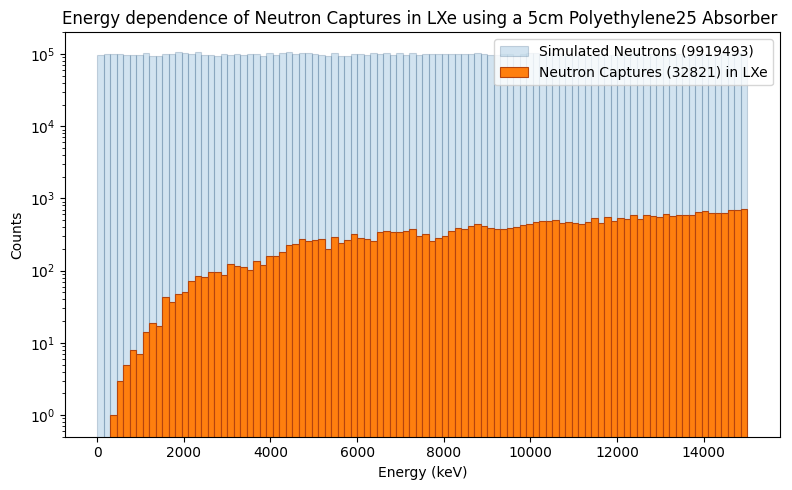

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(e_pri, bins=100, color=colors[0],alpha=0.2, edgecolor = edge_colors[0],linewidth=0.8, label = f'Simulated Neutrons ({e_pri.__len__()})' ) 
plt.hist(e_pri_LXe, bins=100,range=(0, 15000), color = colors[1], alpha = 1, edgecolor=edge_colors[1],linewidth=0.8, label = f'Neutron Captures ({e_pri_LXe.__len__()}) in LXe')  # `bins=20` kannst du anpasse
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.5, 2e5) 
plt.title(f'Energy dependence of Neutron Captures in LXe using a {data_file_pattern} {data_Material} Absorber ')
plt.tight_layout()
plt.legend()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/{data_Material}/{data_file_pattern}_EnergyNC_LXe.pdf" )
plt.show()

### In Absorber

In [12]:
only_Absorber_volume = df[df['NAct_volume'] == "Absorber"]
only_nCapture = only_Absorber_volume[only_Absorber_volume['NAct_process_ID'] == 131]  #nCapture
data = only_nCapture[['e_pri']]

In [13]:
with ProgressBar():
    e_pri = df_pri['e_pri'].compute()
    e_pri_Absorber = data['e_pri'].compute()

[########################################] | 100% Completed | 3.00 sms
[########################################] | 100% Completed | 51.37 s


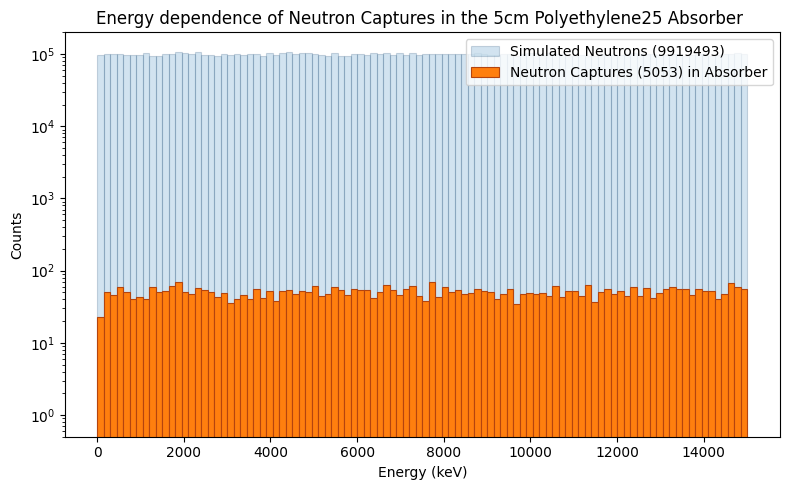

In [14]:
plt.figure(figsize=(8, 5))
plt.hist(e_pri, bins=100, color=colors[0],alpha=0.2, edgecolor = edge_colors[0],linewidth=0.8, label = f'Simulated Neutrons ({e_pri.__len__()})' ) 
plt.hist(e_pri_Absorber, bins=100,range=(0, 15000), color = colors[1], alpha = 1, edgecolor=edge_colors[1],linewidth=0.8, label = f'Neutron Captures ({e_pri_Absorber.__len__()}) in Absorber')  # `bins=20` kannst du anpasse
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.yscale('log')
plt.ylim(0.5, 2e5) 
plt.title(f'Energy dependence of Neutron Captures in the {data_file_pattern} {data_Material} Absorber ')
plt.tight_layout()
plt.legend()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/{data_Material}/{data_file_pattern}_EnergyNC_Absorber.pdf" )
plt.show()

## Processes

In [15]:
da_processes = uproot.dask(uproot_files, filter_name=['e_pri','NAct_particle_id', 'NAct_process_ID', 'NAct_volume'], allow_missing=True, step_size="8GB")

df = da.to_dataframe(da_processes)

### Xenon Volume

In [19]:
only_LXe_volume = df[df['NAct_volume'] == "LXe"]

only_LXe_volume = only_LXe_volume[['NAct_particle_id','NAct_process_ID']]

In [20]:
with ProgressBar():
    grouped_data = only_LXe_volume.groupby(['NAct_particle_id','NAct_process_ID']).size().compute()


grouped_data.index = grouped_data.index.set_levels(
    grouped_data.index.levels[0].map(lambda x: get_particle_name(x)), level = 0
)
grouped_data.index = grouped_data.index.set_levels(
    grouped_data.index.levels[1].map(lambda x: get_process_name(x)), level = 1
)


[########################################] | 100% Completed | 51.70 s


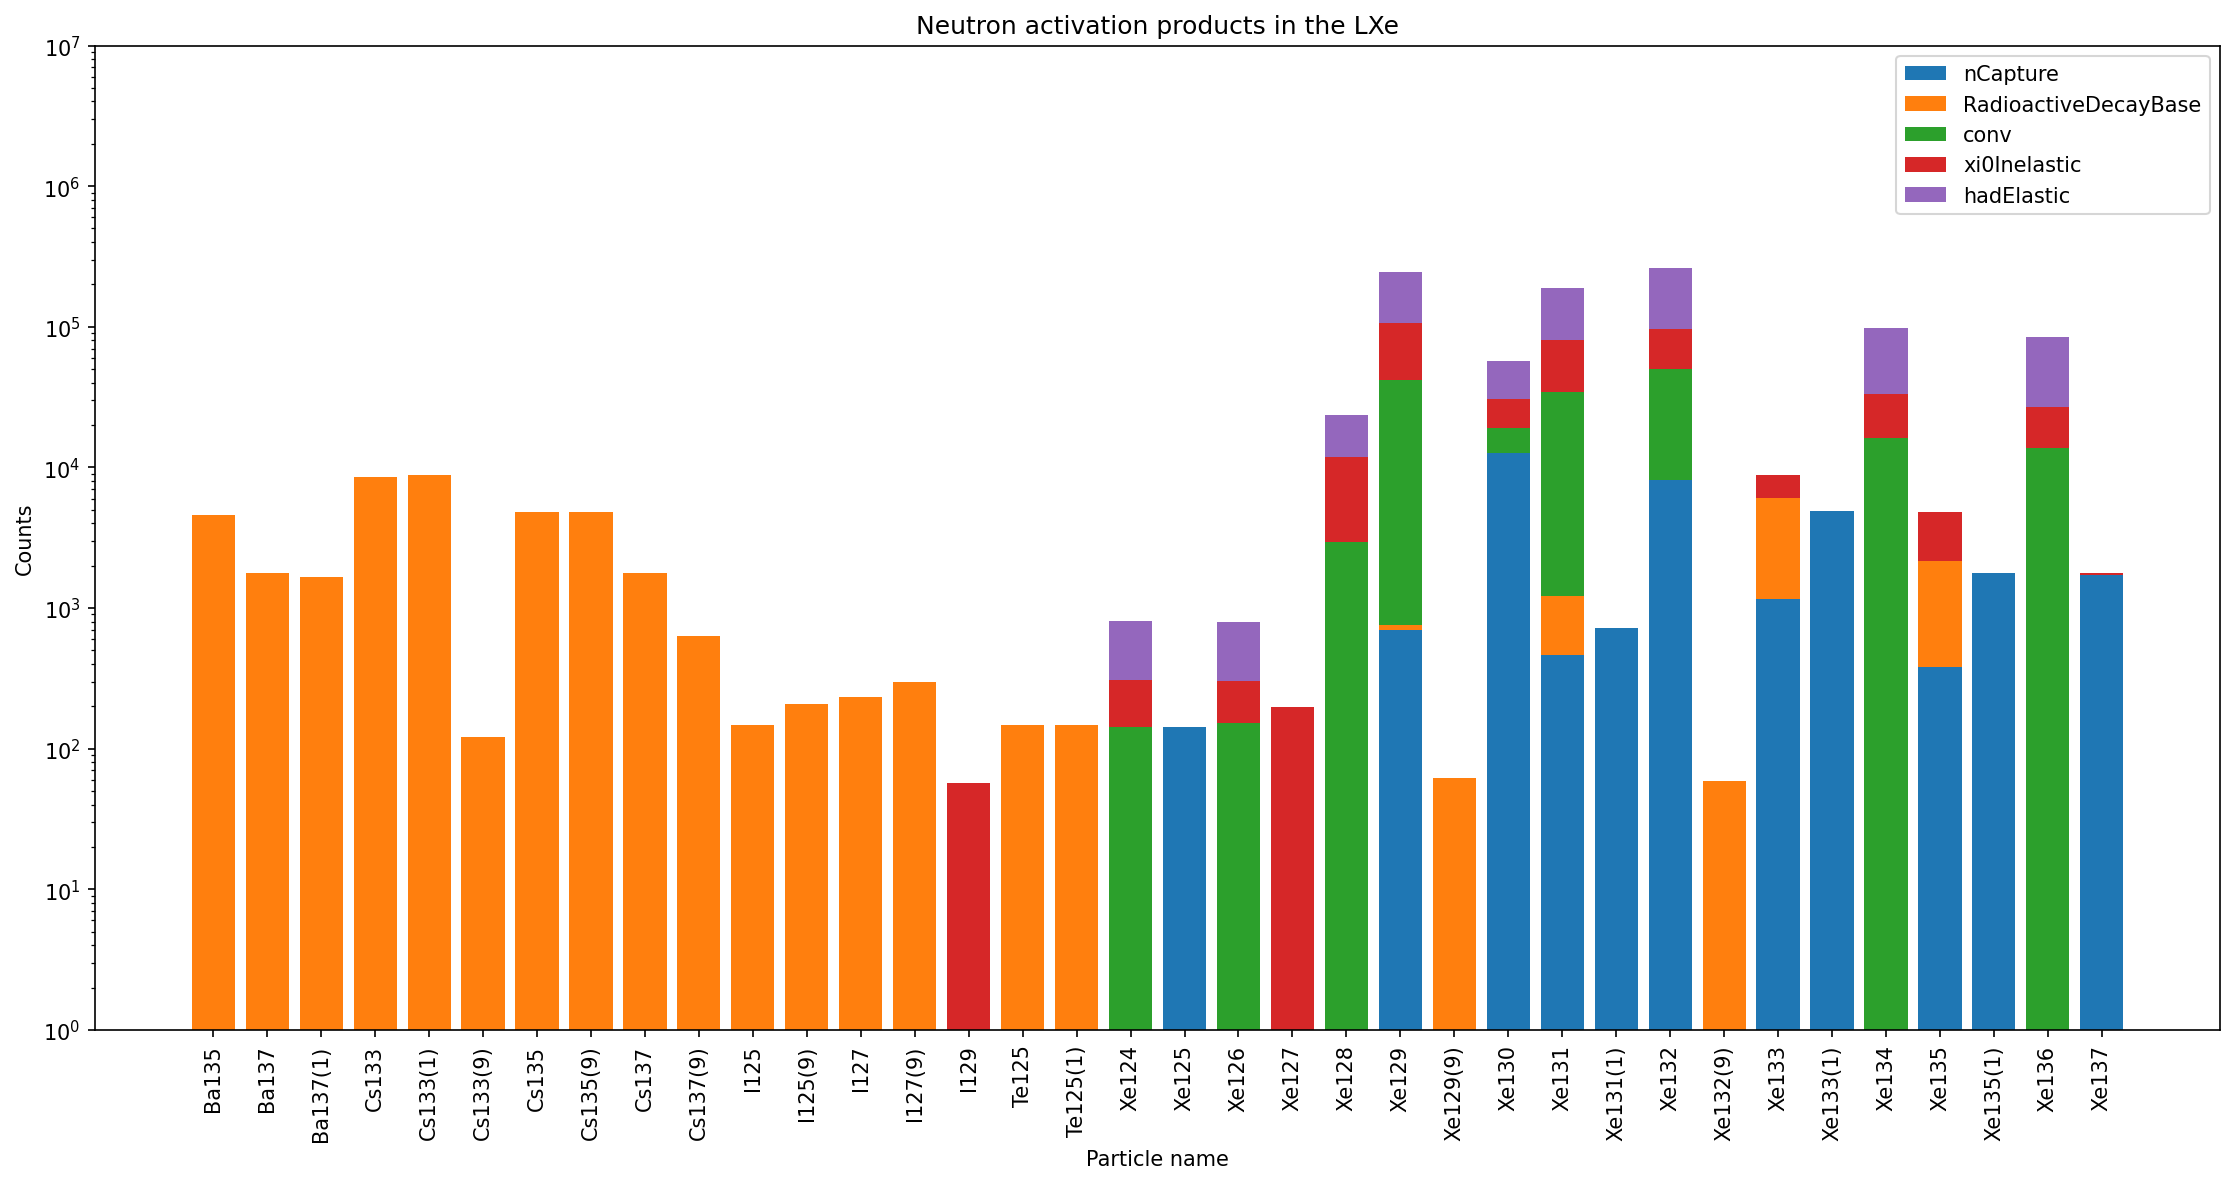

In [21]:
_data = grouped_data[grouped_data.values > 40]

_particles = np.unique(_data.index.get_level_values(0))
_processes = np.unique(_data.index.get_level_values(1))

def get_value(data,pr,p):
    try:
        return data[p,pr]
    except:
        return 0
    
_counts = {pr: [get_value(_data,pr,p) for p in _particles] for pr in _processes} 
_processes_sorted = sorted(_processes, key=lambda pr: sum(_counts[pr]))

plt.figure(dpi=150, figsize =(15,8))

x = np.arange(len(_particles))
bottom = np.zeros(len(_particles))
for pr in _processes_sorted:
    plt.bar(x, _counts[pr], 0.8, label=pr, bottom=bottom)
    bottom += np.array(_counts[pr])

ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(_particles, rotation=90, ha='center')

plt.xlabel("Particle name")
plt.ylabel("Counts")
plt.title("Neutron activation products in the LXe")
plt.yscale("log")
plt.ylim(1,1e7)

plt.legend()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/{data_Material}/{data_file_pattern}_Processes_LXe.pdf" )
plt.tight_layout()
plt.show()





### Absorber Volume

In [22]:
only_Absorber_volume = df[df['NAct_volume'] == "Absorber"]

only_PartProcess = only_Absorber_volume[['NAct_particle_id','NAct_process_ID']]

In [23]:
with ProgressBar():
    grouped_data = only_PartProcess.groupby(['NAct_particle_id','NAct_process_ID']).size().compute()


grouped_data.index = grouped_data.index.set_levels(
    grouped_data.index.levels[0].map(lambda x: get_particle_name(x)), level = 0
)
grouped_data.index = grouped_data.index.set_levels(
    grouped_data.index.levels[1].map(lambda x: get_process_name(x)), level = 1
)


[                                        ] | 0% Completed | 181.09 us

[########################################] | 100% Completed | 51.54 s


In [24]:
_data

NAct_particle_id  NAct_process_ID     
I127              RadioactiveDecayBase    231
I127(9)           RadioactiveDecayBase    300
I129              xi0Inelastic             57
Xe124             conv                    142
                  hadElastic              499
                                         ... 
I125(9)           RadioactiveDecayBase    207
Xe125             nCapture                142
Xe131             nCapture                464
Xe132(9)          RadioactiveDecayBase     59
Cs133(9)          RadioactiveDecayBase    120
Length: 65, dtype: int64

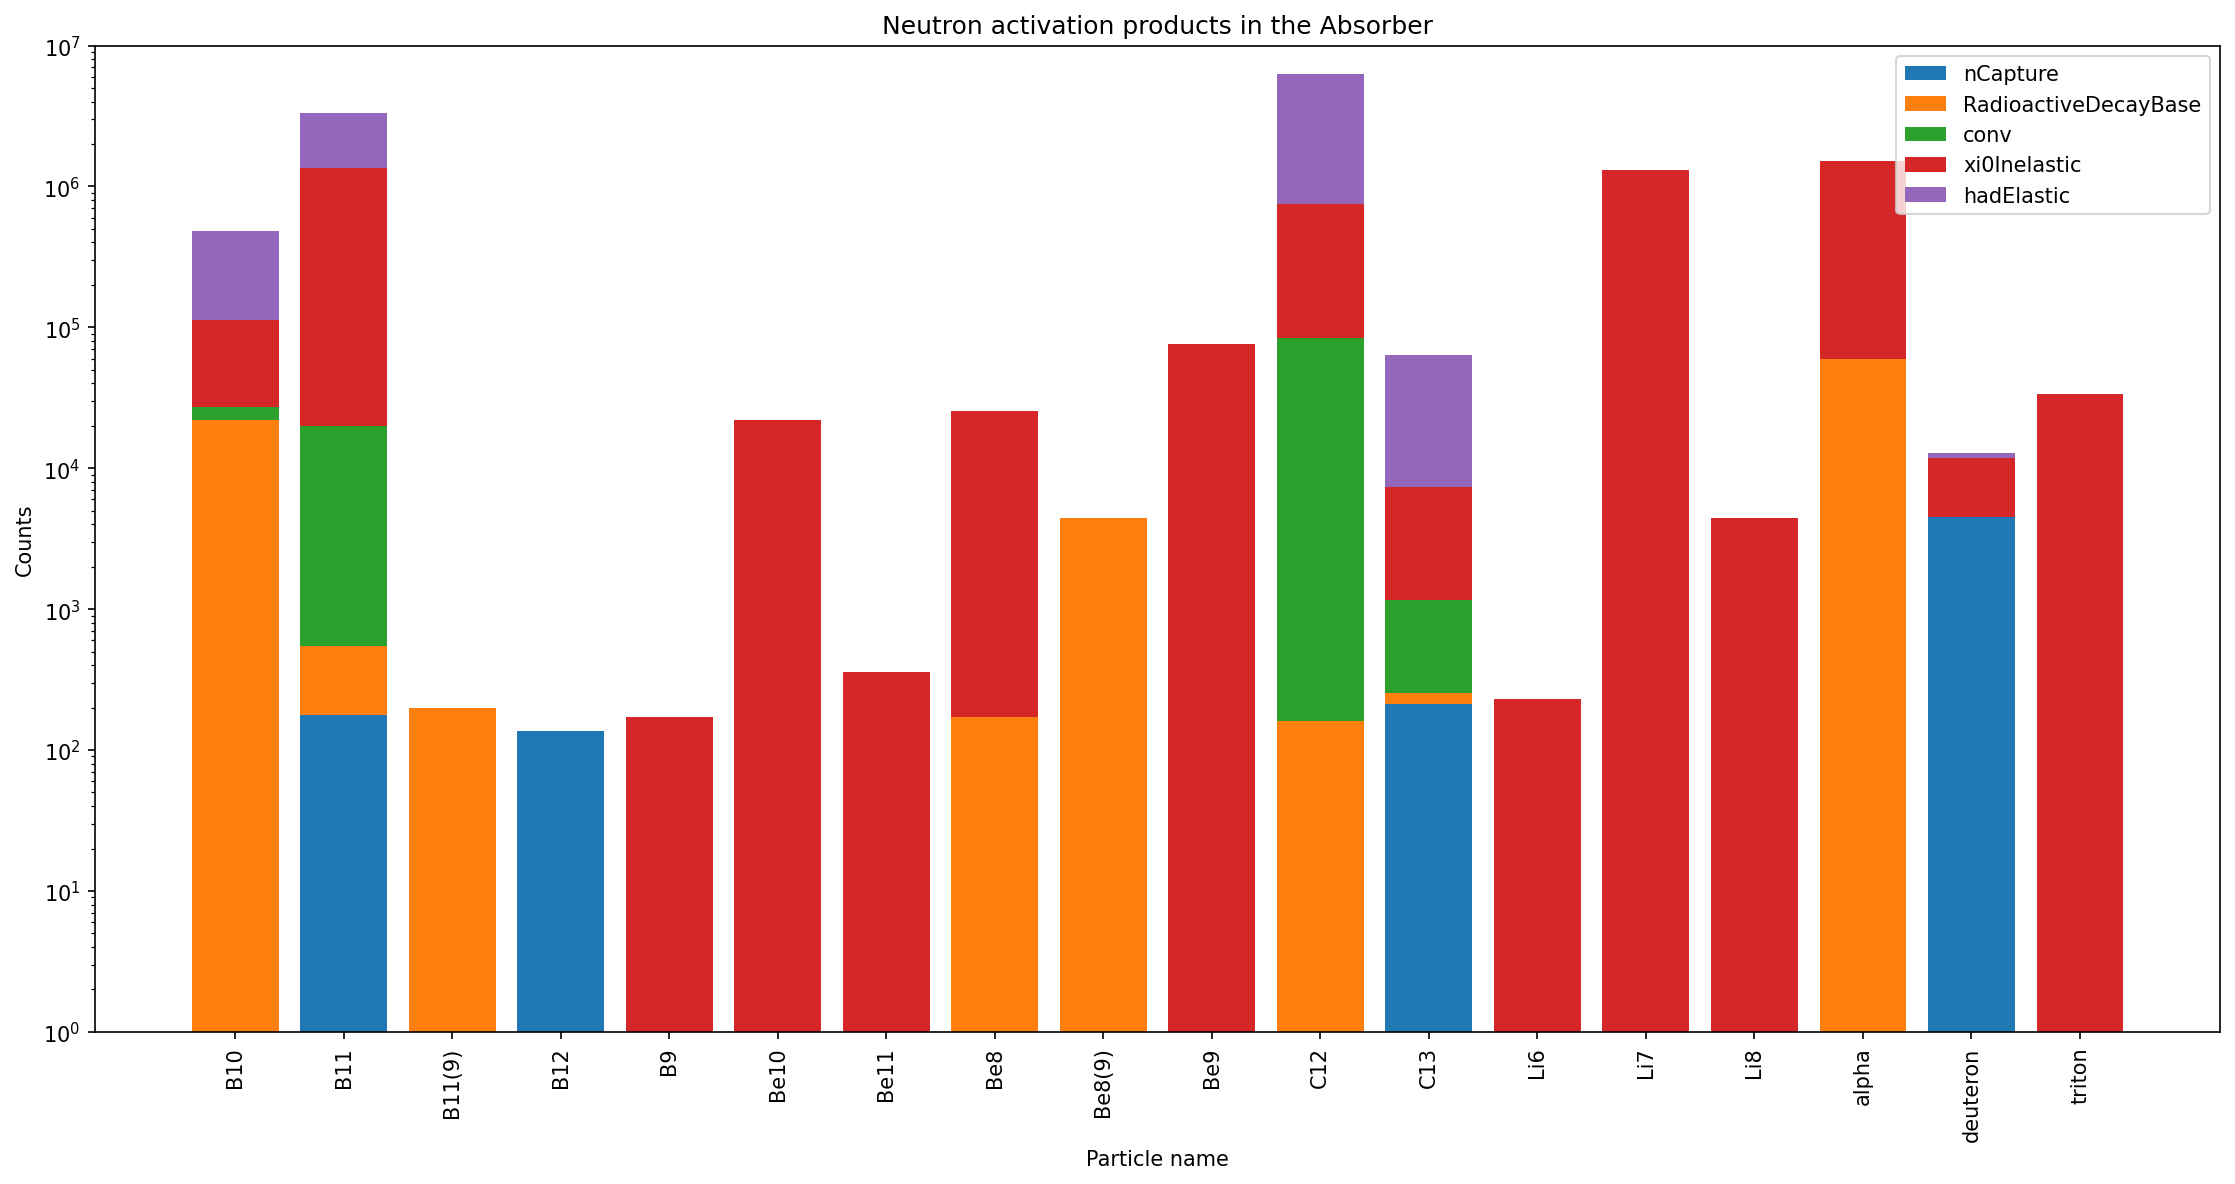

In [25]:
_data = grouped_data[grouped_data.values > 40]
#_data = grouped_data

_particles = np.unique(_data.index.get_level_values(0))
_processes = np.unique(_data.index.get_level_values(1))



def get_value(data,pr,p):
    try:
        return data[p,pr]
    except:
        return 0

_counts = {pr: [get_value(_data,pr,p) for p in _particles] for pr in _processes} 
_processes_sorted = sorted(_processes, key=lambda pr: sum(_counts[pr]))

plt.figure(dpi=150, figsize =(15,8))

x = np.arange(len(_particles))
bottom = np.zeros(len(_particles))
for pr in _processes_sorted:
    plt.bar(x, _counts[pr], 0.8, label=pr, bottom=bottom)
    bottom += np.array(_counts[pr])

ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(_particles, rotation=90, ha='center')

plt.xlabel("Particle name")
plt.ylabel("Counts")
plt.title("Neutron activation products in the Absorber")
plt.yscale("log")
plt.ylim(1,1e7)

plt.legend()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/{data_Material}/{data_file_pattern}_Processes_Absorber.pdf" )
plt.tight_layout()
plt.show()



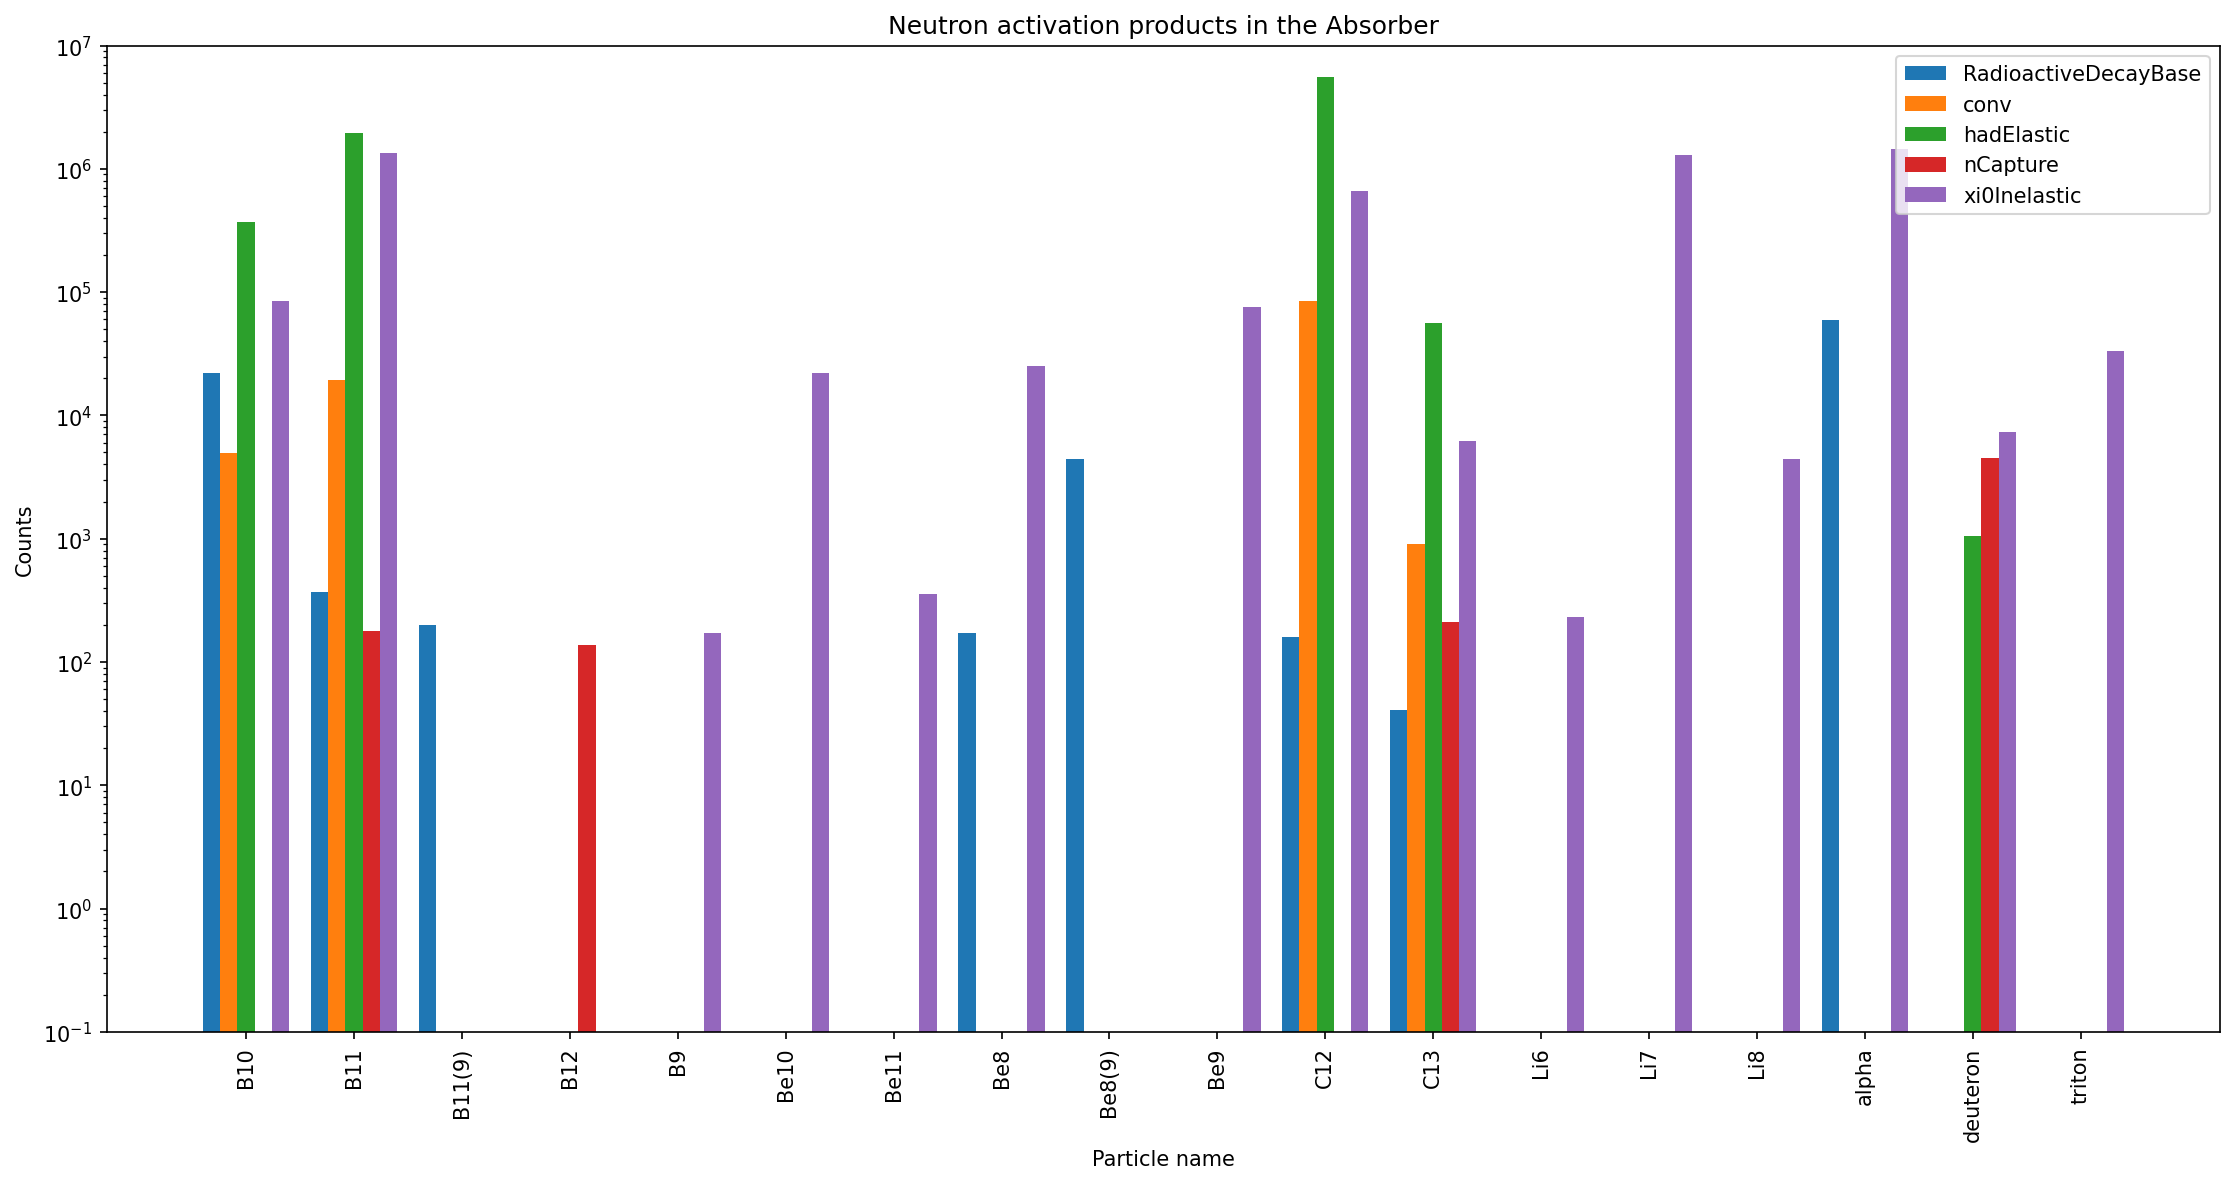

In [26]:
plt.figure(dpi=150, figsize=(15, 8))

x = np.arange(len(_particles))
bar_width = 0.8 / len(_processes)  # Balken schmaler machen, damit sie nebeneinander passen

for i, pr in enumerate(_processes):
    plt.bar(x + i * bar_width, _counts[pr], bar_width, label=pr)

ax = plt.gca()
ax.set_xticks(x + bar_width * (len(_processes)-1)/2)
ax.set_xticklabels(_particles, rotation=90, ha='center')

plt.xlabel("Particle name")
plt.ylabel("Counts")
plt.title("Neutron activation products in the Absorber")
plt.yscale("log")
plt.ylim(0.1, 1e7)
plt.legend()
plt.tight_layout()
plt.show()

## Energy Distributions trend

In [27]:
da_processes = uproot.dask(uproot_files, filter_name=['e_pri', 'type_pri_id','Save_desc', 'Save_e', 'Save_volume'], allow_missing=True, step_size="8GB")
da_processes['type_pri_id'] = ak.flatten(da_processes['type_pri_id'])

df_pri = da.to_dataframe(da_processes[['e_pri','type_pri_id']])
df_pri = df_pri[df_pri['type_pri_id'] == 2112]
df = da.to_dataframe(da_processes[['Save_desc', 'Save_e', 'Save_volume']])

In [28]:
with ProgressBar():
    unique_save_desc = df['Save_desc'].unique().compute()

label = ['Primary Energy']
label += [str(desc) for desc in unique_save_desc]

# If you want to build arrays for each unique Save_desc, do it like this:
arrays = [df_pri['e_pri']]
arrays += [df[df['Save_desc'] == desc]['Save_e'] for desc in unique_save_desc]

[                                        ] | 0% Completed | 222.38 us

[########################################] | 100% Completed | 41.97 s


In [ ]:
unique_save_desc

0    Into Absorber
Name: Save_desc, dtype: string

In [ ]:
for i, cat in enumerate(unique_save_desc):
    match cat:
        case ''
    

In [ ]:
hist_tasks = []
bins = []

for i in range(len(arrays)):
    hist_task, bin_edges = dh.histogram(arrays[i], bins=100, range=(0,15000))
    hist_tasks.append(hist_task)
    bins.append(bin_edges)


In [270]:
with ProgressBar():
    hist_vals_list = [a.compute() for a in hist_tasks]
    bin_edges_list = [b.compute() for b in bins]


[                                        ] | 0% Completed | 170.93 us

[########################################] | 100% Completed | 3.92 sms
[########################################] | 100% Completed | 13.74 s
[########################################] | 100% Completed | 13.65 s
[########################################] | 100% Completed | 13.49 s
[########################################] | 100% Completed | 14.95 s
[########################################] | 100% Completed | 14.85 s
[########################################] | 100% Completed | 101.10 ms
[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 100.88 ms


0
1
4
3
2
5


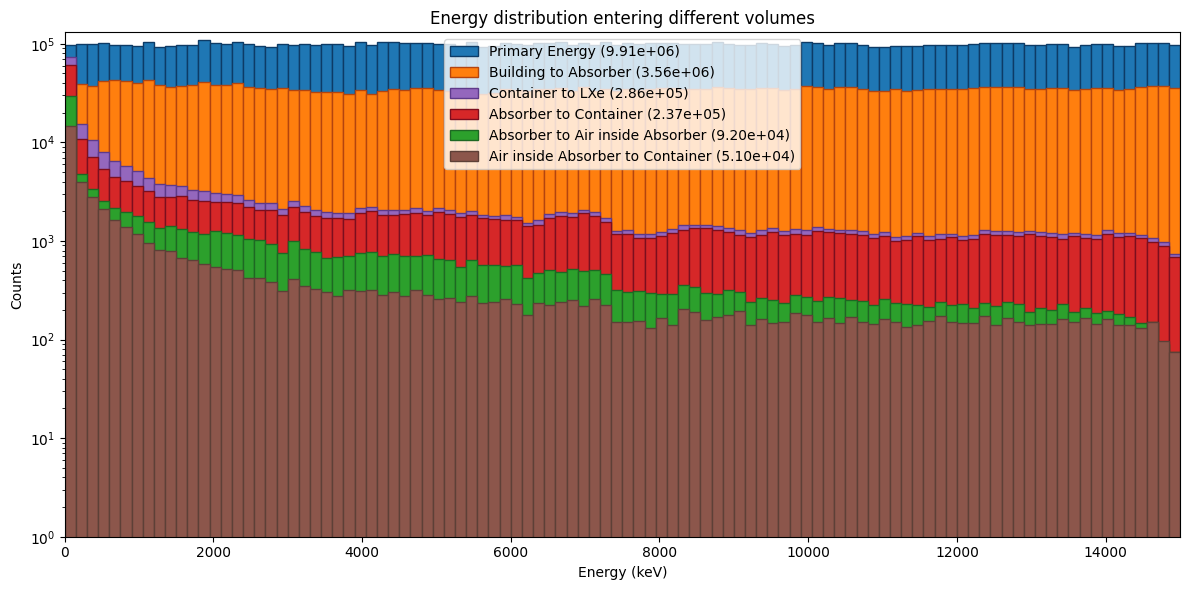

In [271]:
plt.figure(figsize=(12, 6))

all_indices = [
    i for i in range(len(hist_vals_list))
]

# Nach Länge sortieren (absteigend)
all_indices_sorted = sorted(
    all_indices,
    key=lambda i: sum(hist_vals_list[i]),
    reverse=True
)

for i in all_indices_sorted:
    print(i)
    plt.bar(bin_edges_list[i][:-1], hist_vals_list[i],
            width=bin_edges_list[i][1] - bin_edges_list[i][0],
            align='edge',
            color=colors[i], edgecolor=edge_colors[i],
            label=f'{label[i]} ({sum(hist_vals_list[i]):.2e})',
            alpha=1)

plt.xlim(0, 15000)

plt.yscale('log')
plt.ylim(1, 1.2 * max(hist_vals_list[0].max(), hist_vals_list[1].max()))

plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('Energy distribution entering different volumes')
plt.tight_layout()
plt.legend()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/{data_Material}/{data_file_pattern}_EnergyDistributions_Volumes.pdf" )
plt.show()

## Positions

In [184]:
da_positions_pri = uproot.dask(uproot_files, filter_name=['eventid','xp_pri', 'yp_pri', 'zp_pri','type_pri_id', 'vol_pri' ], allow_missing=True, step_size="2GB")
da_positions_NAct = uproot.dask(uproot_files, filter_name=['eventid','NAct_volume', 'NAct_x', 'NAct_y', 'NAct_z' ], allow_missing=True, step_size="2GB")

df_pri = da.to_dataframe(da_positions_pri)
df_NAct = da.to_dataframe(da_positions_NAct)

In [185]:
neutron = 2112

data_pri = df_pri[df_pri['type_pri_id'] == neutron]


In [35]:
x_range = (data_pri['xp_pri'].min().compute(), data_pri['xp_pri'].max().compute())
y_range = (data_pri['yp_pri'].min().compute(), data_pri['yp_pri'].max().compute())
z_range = (data_pri['zp_pri'].min().compute(), data_pri['zp_pri'].max().compute())



KeyboardInterrupt: 

In [ ]:
h = dh.histogramdd([data_pri["xp_pri"], data_pri["yp_pri"], data_pri["zp_pri"]], 
                   bins=(100, 100, 100), 
                   range=(x_range, y_range, z_range), histogram=True)


In [ ]:
h.compute()

TypeError: Converting from an nplike without known data to an nplike with known data is not supported

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(np.sum(h.compute(), axis=2), extent=(x_range[0], x_range[1], y_range[0], y_range[1]), origin='lower', aspect='auto')
plt.colorbar(label='Counts')
plt.xlabel('X Position (cm)')
plt.ylabel('Y Position (cm)')
plt.show()

TypeError: Converting from an nplike without known data to an nplike with known data is not supported

<Figure size 1000x800 with 0 Axes>

# Loading multiple Files using dask

## Random Kombination in one Plot

In [7]:
data_path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron"
data_Version = "0ad7977"
data_Material = [['Air',"Water",'Polyethylene', 'Polyethylene5', 'Polyethylene25'],['Polyethylene25']]
data_AbsorberThick = ['5cm','50cm' ]
data_file_pattern = [
    f"{data_AbsorberThick[i]}" for i in range(len(data_AbsorberThick))
]

min_data_file_size = 5 * 1024 * 1024  # z.B. 5MB




# Angenommen, data_file_pattern ist eine Liste von Listen oder eine 2D-Struktur:
# Beispiel: data_file_pattern = [['50cm_point'], ['anderer_pattern'], ...]
data_files = [
    [glob.glob(f"{data_path}/{data_Version}/{data_Material[j][i]}/{data_file_pattern[j]}_*.root")
        for i in range(len(data_Material[j]))]  # Beachte: Indexierung anpassen, falls data_file_pattern[j] eine Liste ist
    for j in range(len(data_AbsorberThick))
]

# Wiederhole es für uproot_files:
uproot_files = [
    [  # Liste für jedes Material
        [{f: "events/events"} for f in data_files[j][i] if os.path.getsize(f) > min_data_file_size]
        for i in range(len(data_Material[j]))
    ]
    for j in range(len(data_AbsorberThick))
]


In [8]:
pictures_path = '/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures'
if not os.path.exists(f'{pictures_path}/{data_Version}/all'):
    os.makedirs(f'{pictures_path}/{data_Version}/all')

In [9]:
e_pri_2 = [ [None] * len(uproot_files[j]) for j in range(len(data_AbsorberThick)) ]
k = 1
for j,thick in enumerate(data_AbsorberThick):
    for i,file in enumerate(uproot_files[j]):
        print(f'Files: {k}/{sum(len(inner) for inner in uproot_files)}', f'{data_Material[j][i]}/{thick}_* ')


        print('Loading Files... First time might take a minute')
        start_time = time.time()

        da_processes = uproot.dask(file, filter_name=['eventid','e_pri','type_pri_id','NAct_volume', 'NAct_process_ID'], allow_missing=True, step_size="8GB")
        df = da.to_dataframe(da_processes)

        end_time = time.time()
        print(f"Loading time: {(end_time - start_time)/60:.2f} minutes")
        

        only_LXe_volume = df[df['NAct_volume'] == "LXe"]
        only_primary_neutrons = only_LXe_volume[only_LXe_volume['type_pri_id'] == 2112]
        only_nCapture = only_primary_neutrons[only_primary_neutrons['NAct_process_ID'] == 131]  #nCapture

        data = only_nCapture[['e_pri']]
        e_pri_2[j][i] = data['e_pri']
        
        k += 1
        
        

Files: 1/6 Air/5cm_* 
Loading Files... First time might take a minute
Loading time: 1.54 minutes
Files: 2/6 Water/5cm_* 
Loading Files... First time might take a minute
Loading time: 1.82 minutes
Files: 3/6 Polyethylene/5cm_* 
Loading Files... First time might take a minute
Loading time: 1.67 minutes
Files: 4/6 Polyethylene5/5cm_* 
Loading Files... First time might take a minute
Loading time: 1.60 minutes
Files: 5/6 Polyethylene25/5cm_* 
Loading Files... First time might take a minute
Loading time: 1.68 minutes
Files: 6/6 Polyethylene25/50cm_* 
Loading Files... First time might take a minute
Loading time: 1.65 minutes


In [10]:
k=1
for j,thick in enumerate(data_AbsorberThick):
    for i,file in enumerate(uproot_files[j]):
        print(f'Files: {k}/{sum(len(inner) for inner in uproot_files)}', f'{data_Material[j][i]}/{thick}_* ')
        with ProgressBar():
            e_pri_2[j][i] = e_pri_2[j][i].compute()
        k+=1

Files: 1/6 Air/5cm_* 
[########################################] | 100% Completed | 55.80 s
Files: 2/6 Water/5cm_* 
[########################################] | 100% Completed | 50.89 s
Files: 3/6 Polyethylene/5cm_* 
[########################################] | 100% Completed | 57.04 s
Files: 4/6 Polyethylene5/5cm_* 
[########################################] | 100% Completed | 58.03 s
Files: 5/6 Polyethylene25/5cm_* 
[########################################] | 100% Completed | 57.47 s
Files: 6/6 Polyethylene25/50cm_* 
[########################################] | 100% Completed | 54.56 s


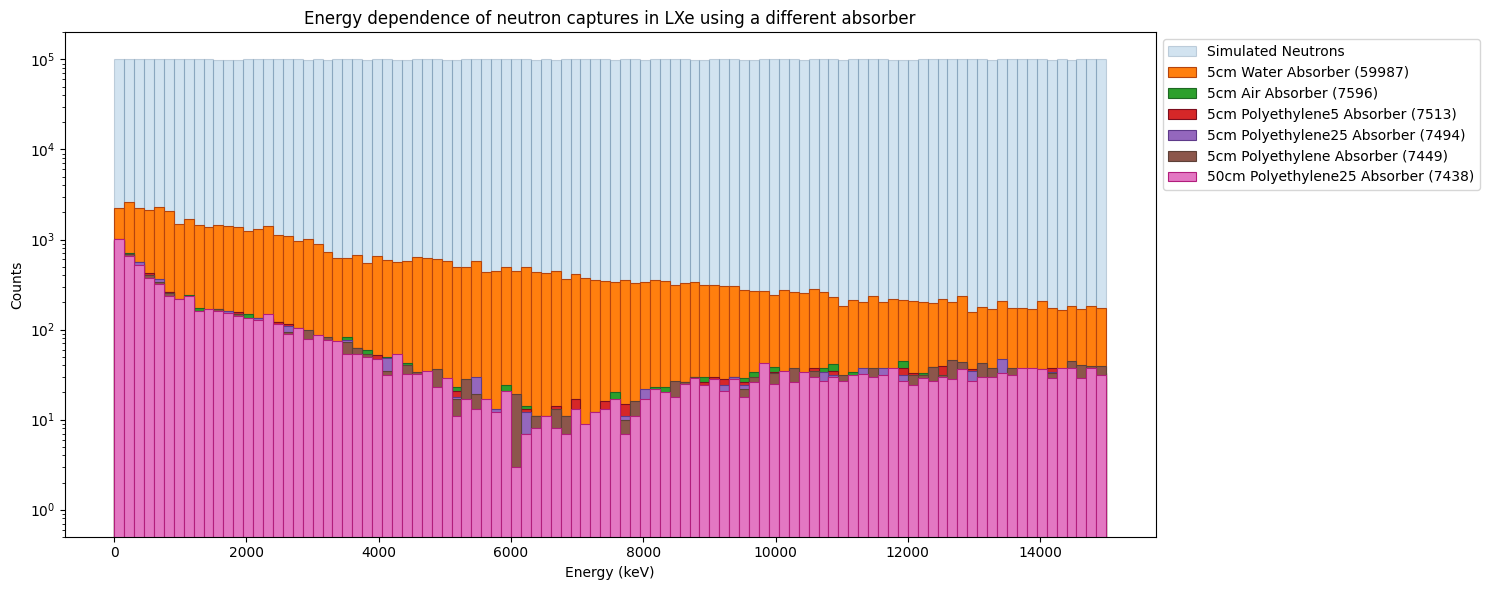

In [12]:
all_indices = [
    (j, i)
    for j in range(len(e_pri_2))
    for i in range(len(e_pri_2[j]))
]

# Nach Länge sortieren (absteigend)
all_indices_sorted = sorted(
    all_indices,
    key=lambda tup: len(e_pri_2[tup[0]][tup[1]]),
    reverse=True
)

fig, ax = plt.subplots(figsize=(15, 6))

sim = np.random.uniform(low=0, high=15000, size=10000000)
ax.hist(sim, bins=100, edgecolor=edge_colors[0], linewidth=0.8, color=colors[0], alpha=0.2, label='Simulated Neutrons')

k = 1
for j, i in all_indices_sorted:
    ax.hist(
        e_pri_2[j][i],
        bins=100,
        range=(0, 15000),
        color=colors[k % len(colors)],
        alpha=1,
        edgecolor=edge_colors[k % len(edge_colors)],
        linewidth=0.8,
        label=f'{data_AbsorberThick[j]} {data_Material[j][i]} Absorber ({len(e_pri_2[j][i])})'
    )
    k += 1

ax.set_yscale('log')
ax.set_ylim(0.5, 2e5) 
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Counts')
ax.set_title(f'Energy dependence of neutron captures in LXe using a different absorber')

plt.tight_layout()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/all/MaterialComparison_EnergyNC.pdf" )
plt.show()

## Different Thicknesses

In [21]:
data_path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron"
data_Version = "e44f72e"
data_Material = ['Air',"G4_Water"]
data_AbsorberThick = [['5cm'],["5cm","10cm","20cm","30cm","50cm","70cm","100cm"]]
data_file_pattern = [
    [f"{data_AbsorberThick[j][i]}_point" for i in range(len(data_AbsorberThick[j]))]
    for j in range(len(data_Material))
]

min_data_file_size = 5 * 1024 * 1024  # z.B. 5MB




# Angenommen, data_file_pattern ist eine Liste von Listen oder eine 2D-Struktur:
# Beispiel: data_file_pattern = [['50cm_point'], ['anderer_pattern'], ...]
data_files = [
    [glob.glob(f"{data_path}/{data_Version}/{data_Material[j]}/{data_file_pattern[j][i]}_*.root")
        for i in range(len(data_file_pattern[j]))]  # Beachte: Indexierung anpassen, falls data_file_pattern[j] eine Liste ist
    for j in range(len(data_Material))
]

# Wiederhole es für uproot_files:
uproot_files = [
    [  # Liste für jedes Material
        [{f: "events/events"} for f in data_files[j][i] if os.path.getsize(f) > min_data_file_size]
        for i in range(len(data_file_pattern[j]))
    ]
    for j in range(len(data_Material))
]


In [22]:
pictures_path = '/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures'
if not os.path.exists(f'{pictures_path}/{data_Version}/all'):
    os.makedirs(f'{pictures_path}/{data_Version}/all')

In [23]:
e_pri_2 = [ [None] * len(uproot_files[j]) for j in range(len(data_Material)) ]
k = 1
for j,material in enumerate(data_Material):
    for i,file in enumerate(uproot_files[j]):
        print(f'Files: {k}/{sum(len(inner) for inner in uproot_files)}', f'{material}/{data_AbsorberThick[j][i]}_point_* ')


        print('Loading Files... First time might take a minute')
        start_time = time.time()

        da_processes = uproot.dask(file, filter_name=['eventid','e_pri','type_pri_id','NAct_volume', 'NAct_process_ID'], allow_missing=True, step_size="4GB")
        df = da.to_dataframe(da_processes)

        end_time = time.time()
        print(f"Loading time: {(end_time - start_time)/60:.2f} minutes")
        

        only_LXe_volume = df[df['NAct_volume'] == "LXe"]
        only_primary_neutrons = only_LXe_volume[only_LXe_volume['type_pri_id'] == 2112]
        only_nCapture = only_primary_neutrons[only_primary_neutrons['NAct_process_ID'] == 131]  #nCapture

        data = only_nCapture[['e_pri']]
        e_pri_2[j][i] = data['e_pri']
        
        k += 1
        
        

Files: 1/8 Air/5cm_point_* 
Loading Files... First time might take a minute
Loading time: 1.52 minutes
Files: 2/8 G4_Water/5cm_point_* 
Loading Files... First time might take a minute
Loading time: 0.22 minutes
Files: 3/8 G4_Water/10cm_point_* 
Loading Files... First time might take a minute
Loading time: 0.26 minutes
Files: 4/8 G4_Water/20cm_point_* 
Loading Files... First time might take a minute
Loading time: 0.20 minutes
Files: 5/8 G4_Water/30cm_point_* 
Loading Files... First time might take a minute
Loading time: 1.36 minutes
Files: 6/8 G4_Water/50cm_point_* 
Loading Files... First time might take a minute
Loading time: 1.37 minutes
Files: 7/8 G4_Water/70cm_point_* 
Loading Files... First time might take a minute
Loading time: 1.45 minutes
Files: 8/8 G4_Water/100cm_point_* 
Loading Files... First time might take a minute
Loading time: 1.14 minutes


In [24]:
k=1
for j,material in enumerate(data_Material):
    for i,file in enumerate(uproot_files[j]):
        print(f'{k}/{sum(len(inner) for inner in uproot_files)}', data_AbsorberThick[j][i], material)
        with ProgressBar():
            e_pri_2[j][i] = e_pri_2[j][i].compute()
        k+=1

1/8 5cm Air
[                                        ] | 0% Completed | 101.87 ms

[########################################] | 100% Completed | 60.04 s
2/8 5cm G4_Water
[########################################] | 100% Completed | 56.82 s
3/8 10cm G4_Water
[########################################] | 100% Completed | 52.65 s
4/8 20cm G4_Water
[########################################] | 100% Completed | 52.00 s
5/8 30cm G4_Water
[########################################] | 100% Completed | 52.35 s
6/8 50cm G4_Water
[########################################] | 100% Completed | 51.57 s
7/8 70cm G4_Water
[########################################] | 100% Completed | 54.18 s
8/8 100cm G4_Water
[########################################] | 100% Completed | 51.10 s


0
1


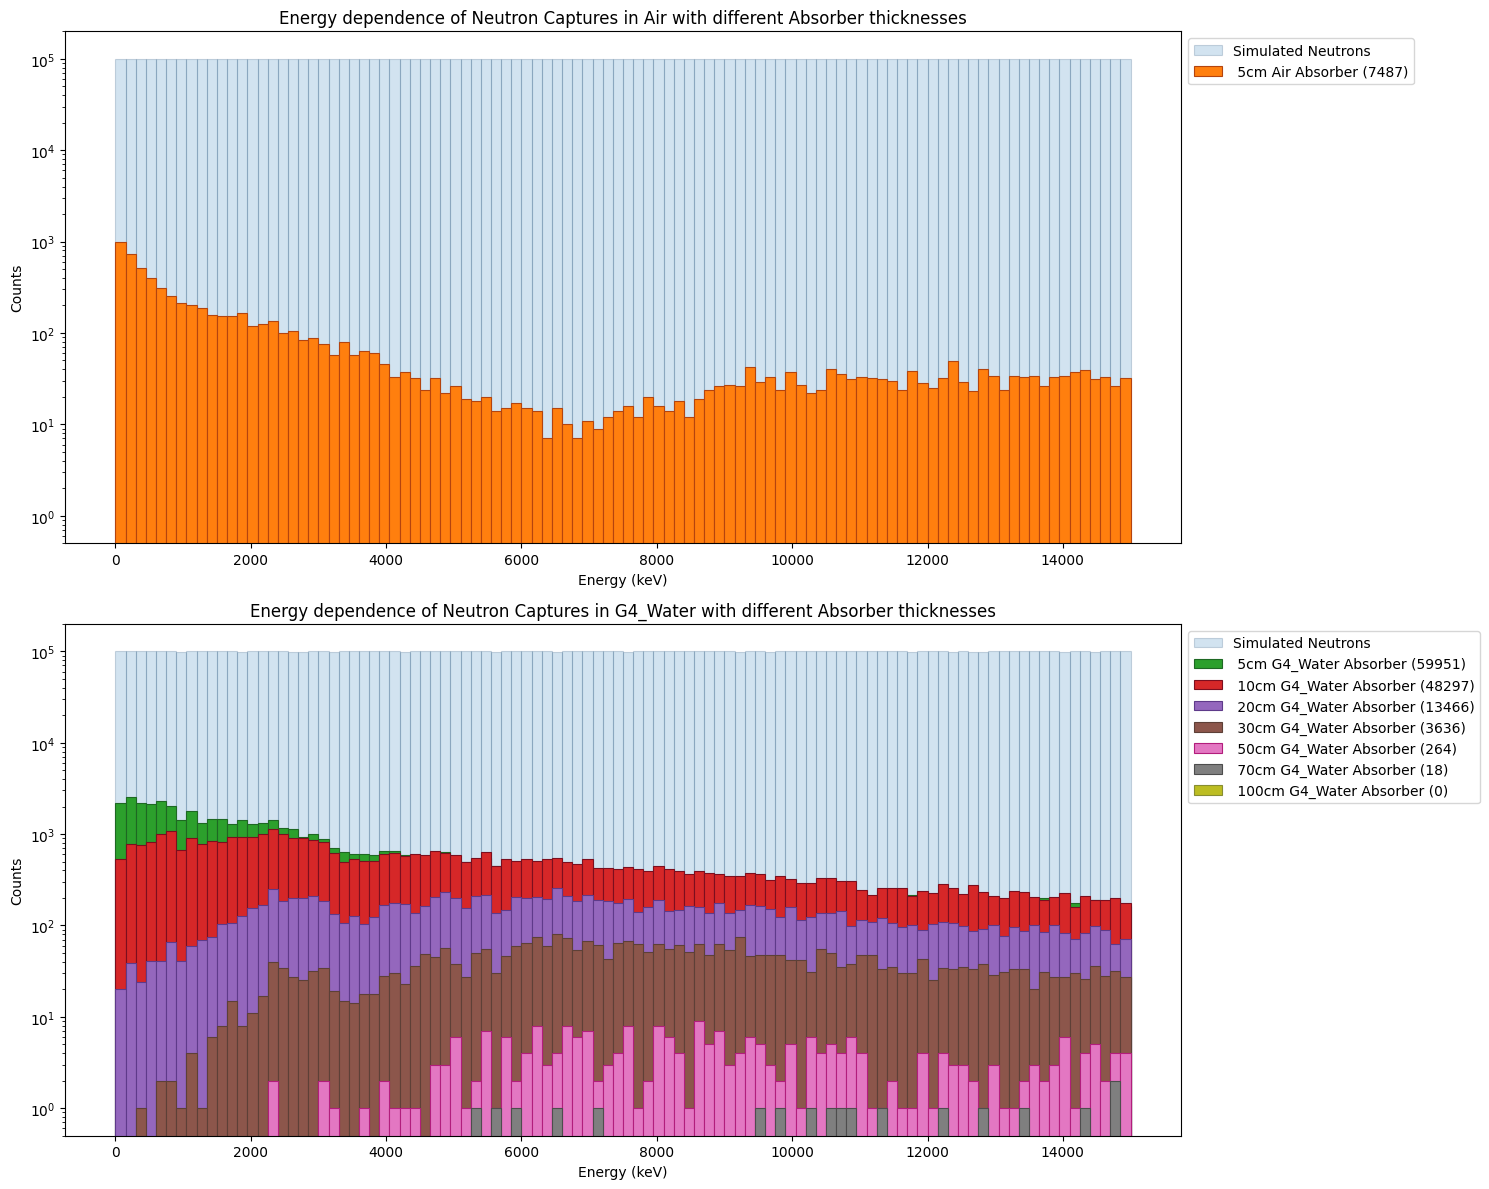

In [ ]:
k=1

fig, ax = plt.subplots(nrows=len(uproot_files), ncols=1, figsize=(15, len(uproot_files)*6))  # 2 Zeilen, 1 Spalte


for j,material in enumerate(data_Material):
    print(j)


    sim = np.random.uniform(low=0, high=15000, size=10000000)
    ax[j].hist(sim, bins=100, edgecolor=edge_colors[0],linewidth = 0.8, color = colors[0],alpha=0.2, label = 'Simulated Neutrons' ) 


    
    for i,file in enumerate(uproot_files[j]):  
            ax[j].hist(e_pri_2[j][i], bins=100,range=(0, 15000), color = colors[k], alpha = 1, edgecolor=edge_colors[k],linewidth=0.8, label = f' {data_AbsorberThick[j][i]} {material} Absorber ({e_pri_2[j][i].__len__()})')  # `bins=20` kannst du anpasse
            k += 1

for i,axs in enumerate(ax):
    axs.set_yscale('log')
    axs.set_ylim(0.5, 2e5) 
    axs.legend(loc="upper left", bbox_to_anchor=(1, 1))
    axs.set_xlabel('Energy (keV)')
    axs.set_ylabel('Counts')
    axs.set_title(f'Energy dependence of neutron captures in LXe using a different absorber')
    
plt.tight_layout()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/all/ThicknessComparison_EnergyNC.pdf" )
plt.show()

## Different Materials

In [22]:
data_path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron"
data_Version = "0ad7977"
data_Material = [['Air',"Water",'Polyethylene', 'Polyethylene5', 'Polyethylene25'],[]]
data_AbsorberThick = ['5cm' ]
data_file_pattern = [
    f"{data_AbsorberThick[i]}" for i in range(len(data_AbsorberThick))
]

min_data_file_size = 5 * 1024 * 1024  # z.B. 5MB




# Angenommen, data_file_pattern ist eine Liste von Listen oder eine 2D-Struktur:
# Beispiel: data_file_pattern = [['50cm_point'], ['anderer_pattern'], ...]
data_files = [
    [glob.glob(f"{data_path}/{data_Version}/{data_Material[j][i]}/{data_file_pattern[j]}_*.root")
        for i in range(len(data_Material[j]))]  # Beachte: Indexierung anpassen, falls data_file_pattern[j] eine Liste ist
    for j in range(len(data_AbsorberThick))
]

# Wiederhole es für uproot_files:
uproot_files = [
    [  # Liste für jedes Material
        [{f: "events/events"} for f in data_files[j][i] if os.path.getsize(f) > min_data_file_size]
        for i in range(len(data_Material[j]))
    ]
    for j in range(len(data_AbsorberThick))
]


In [23]:
pictures_path = '/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures'
if not os.path.exists(f'{pictures_path}/{data_Version}/all'):
    os.makedirs(f'{pictures_path}/{data_Version}/all')

In [24]:
e_pri_2 = [ [None] * len(uproot_files[j]) for j in range(len(data_AbsorberThick)) ]
k = 1
for j,thick in enumerate(data_AbsorberThick):
    for i,file in enumerate(uproot_files[j]):
        print(f'Files: {k}/{sum(len(inner) for inner in uproot_files)}', f'{data_Material[j][i]}/{thick}_* ')


        print('Loading Files... First time might take a minute')
        start_time = time.time()

        da_processes = uproot.dask(file, filter_name=['eventid','e_pri','type_pri_id','NAct_volume', 'NAct_process_ID'], allow_missing=True, step_size="8GB")
        df = da.to_dataframe(da_processes)

        end_time = time.time()
        print(f"Loading time: {(end_time - start_time)/60:.2f} minutes")
        

        only_LXe_volume = df[df['NAct_volume'] == "LXe"]
        only_primary_neutrons = only_LXe_volume[only_LXe_volume['type_pri_id'] == 2112]
        only_nCapture = only_primary_neutrons[only_primary_neutrons['NAct_process_ID'] == 131]  #nCapture

        data = only_nCapture[['e_pri']]
        e_pri_2[j][i] = data['e_pri']
        
        k += 1
        
        

Files: 1/5 Air/5cm_* 
Loading Files... First time might take a minute
Loading time: 1.49 minutes
Files: 2/5 Water/5cm_* 
Loading Files... First time might take a minute


KeyboardInterrupt: 

In [ ]:
k=1
for j,thick in enumerate(data_AbsorberThick):
    for i,file in enumerate(uproot_files[j]):
        print(f'Files: {k}/{sum(len(inner) for inner in uproot_files)}', f'{data_Material[j][i]}/{thick}_* ')
        with ProgressBar():
            e_pri_2[j][i] = e_pri_2[j][i].compute()
        k+=1

Files: 1/4 Air/5cm_* 
[                                        ] | 0% Completed | 295.49 us

[########################################] | 100% Completed | 62.05 s
Files: 2/4 Water/5cm_* 
[########################################] | 100% Completed | 54.06 s
Files: 3/4 Polyethylene/5cm_* 
[########################################] | 100% Completed | 64.99 s
Files: 4/4 Polyethylene5/5cm_* 
[########################################] | 100% Completed | 65.41 s


0


/tmp/slurm_bkoberg.32748203/ipykernel_217367/2338027727.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(loc="upper left", bbox_to_anchor=(1, 1))


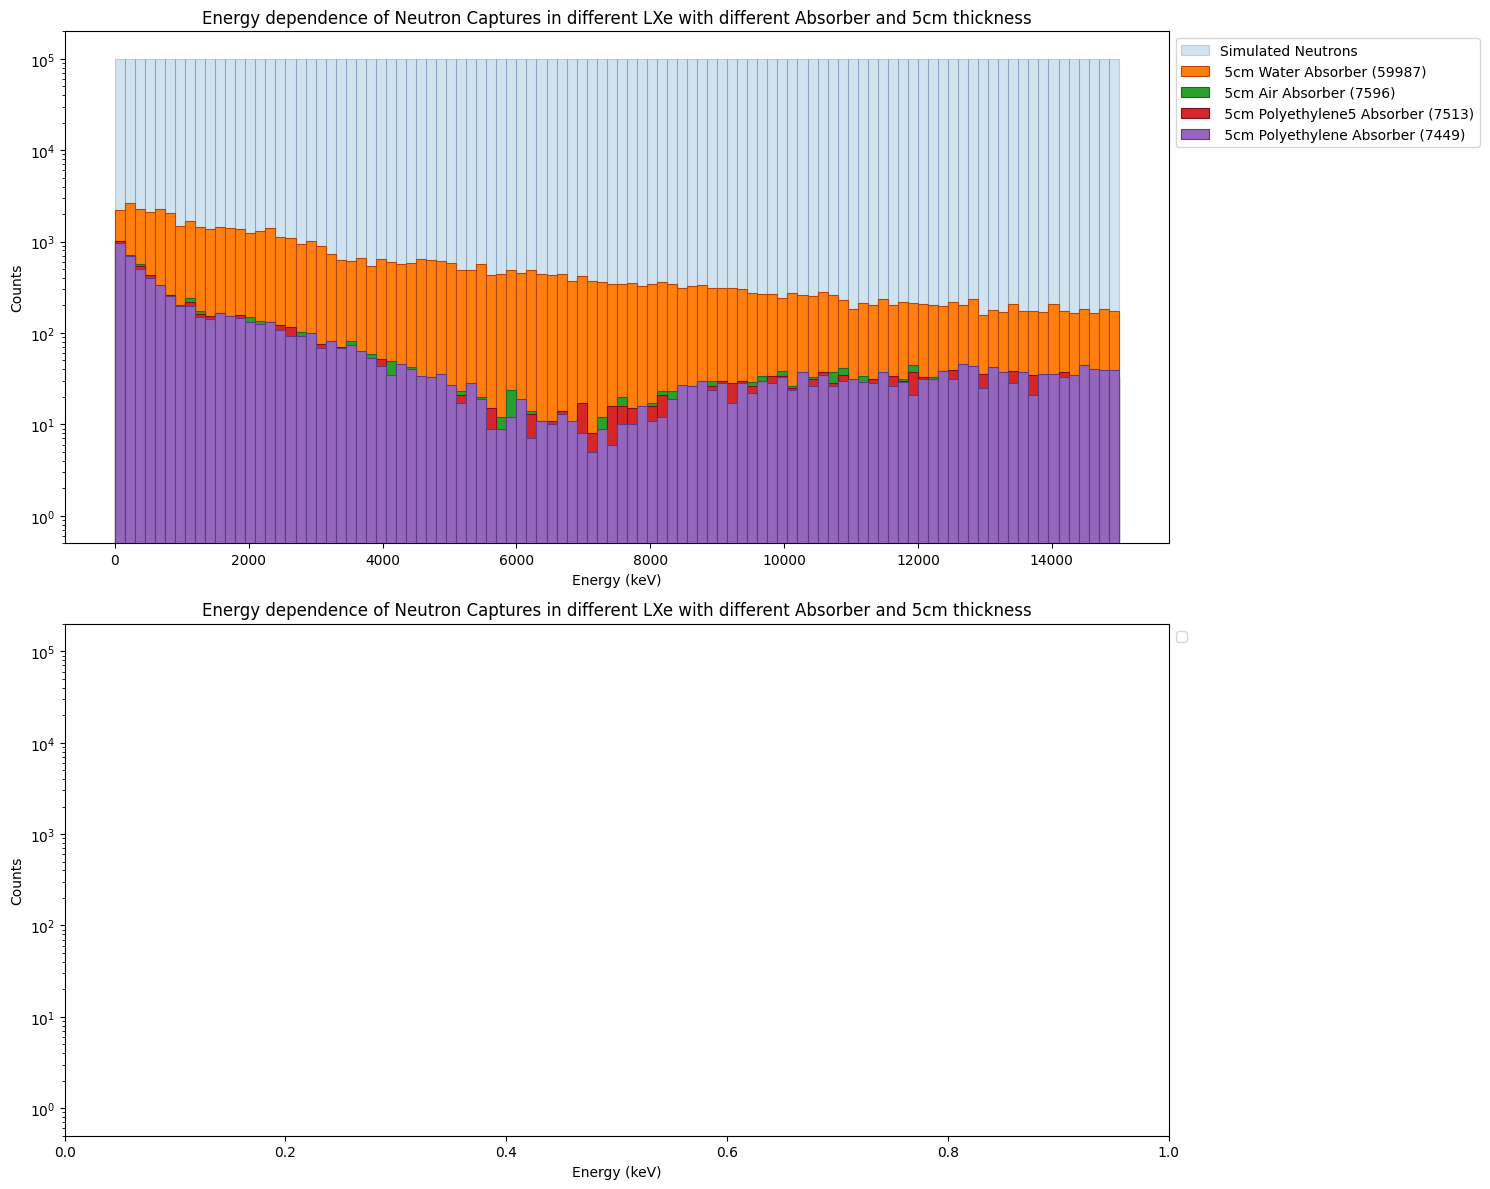

In [ ]:
k=1
if len(uproot_files) > 1:
    fig, ax = plt.subplots(nrows=len(uproot_files), ncols=1, figsize=(15, len(uproot_files)*6))  # 2 Zeilen, 1 Spalte
else:
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))


for j,material in enumerate(data_AbsorberThick):
    print(j)


    sim = np.random.uniform(low=0, high=15000, size=10000000)
    ax[j].hist(sim, bins=100, edgecolor=edge_colors[0],linewidth = 0.8, color = colors[0],alpha=0.2, label = 'Simulated Neutrons' ) 


    
    indices = sorted(range(len(e_pri_2[j])), key=lambda i: len(e_pri_2[j][i]), reverse=True)
    for idx in indices: 
            ax[j].hist(e_pri_2[j][idx], bins=100,range=(0, 15000), color = colors[k], alpha = 1, edgecolor=edge_colors[k],linewidth=0.8, label = f' {thick} {data_Material[j][idx]} Absorber ({e_pri_2[j][idx].__len__()})')  # `bins=20` kannst du anpasse
            k += 1

for i,axs in enumerate(ax):
    axs.set_yscale('log')
    axs.set_ylim(0.5, 2e5) 
    axs.legend(loc="upper left", bbox_to_anchor=(1, 1))
    axs.set_xlabel('Energy (keV)')
    axs.set_ylabel('Counts')
    axs.set_title(f'Energy dependence of neutron captures in LXe using a different absorber')
    
plt.tight_layout()
plt.savefig(f"/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/Pictures/{data_Version}/all/MaterialComparison_EnergyNC.pdf" )
plt.show()

In [ ]:
len(uproot_files)

1